In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline

rcParams['figure.figsize'] = (15,6)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("D://M_AI//Machine Learning//Projects//Proj Datasets//zinc_prices_IMF.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    434 non-null    object 
 1   Price   434 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.9+ KB


In [3]:
df.head()

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07


In [4]:
df.loc[:,'Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01'],
              dtype='datetime64[ns]', name='Date', length=434, freq=None)

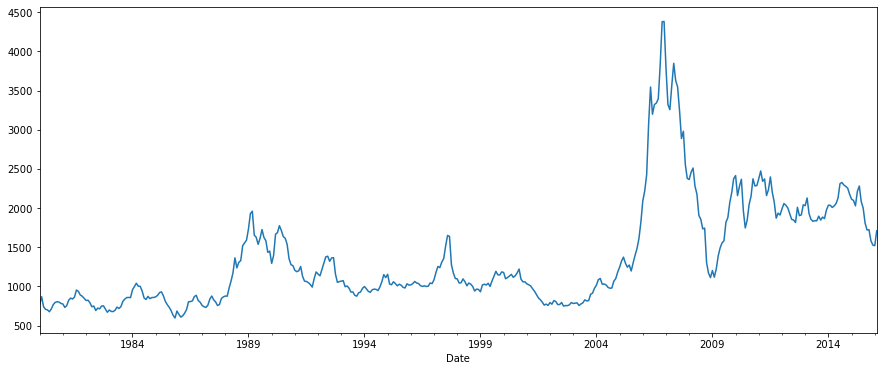

In [5]:
ts = df['Price']
ts.plot()

In [6]:
ts_log = np.log(ts)

In [7]:
# stationarity check
def test_stationarity(timeseries):
    rollmean = timeseries.rolling(window=52,center=False).mean()
    rollstd = timeseries.rolling(window=52,center=False).std()
    
    org = plt.plot(timeseries,color='b',label='original')
    mean = plt.plot(rollmean,color='r',label='Rolling mean')
    std = plt.plot(rollstd,color='black',label = 'Rolling standarddeviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    

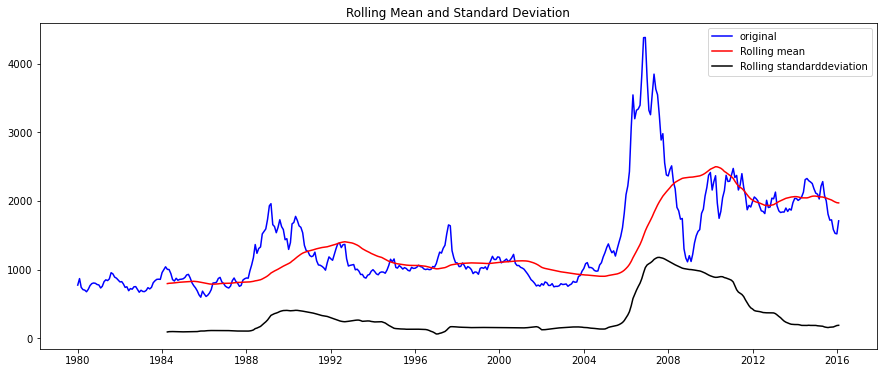

Results of Dickey Fuller Test:
Test Statistic                  -3.139601
p-value                          0.023758
#Lags Used                       7.000000
Number of Observations Used    426.000000
Critical Value (1%)             -3.445794
Critical Value (5%)             -2.868349
Critical Value (10%)            -2.570397
dtype: float64


In [8]:
test_stationarity(df['Price'])

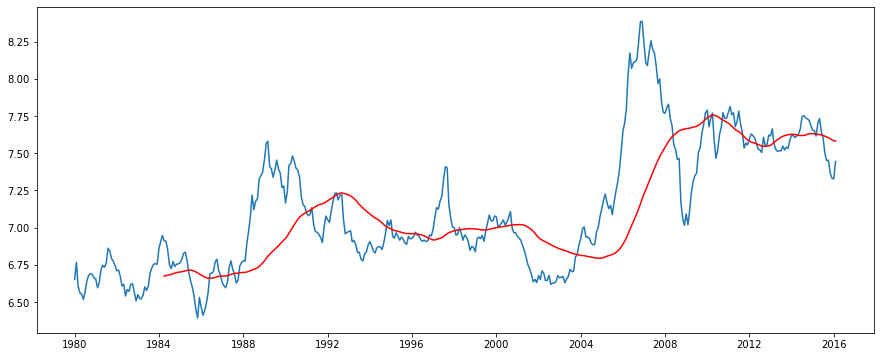

In [9]:
# Calculate moving average and Standard deviation

movingAvg = ts_log.rolling(window = 52,center=False).mean()
movingStd = ts_log.rolling(window = 52,center=False).std()

plt.plot(ts_log)
plt.plot(movingAvg,color='r')

In [10]:
# Differencing
ts_log_mv_diff = ts_log - movingAvg
ts_log_mv_diff.head(12)
ts_log_mv_diff.dropna(inplace=True)

ts_log_mv_diff.head(10)

Date
1984-04-01    0.237445
1984-05-01    0.230301
1984-06-01    0.167436
1984-07-01    0.066364
1984-08-01    0.039692
1984-09-01    0.081990
1984-10-01    0.044357
1984-11-01    0.056329
1984-12-01    0.056700
1985-01-01    0.062736
Name: Price, dtype: float64

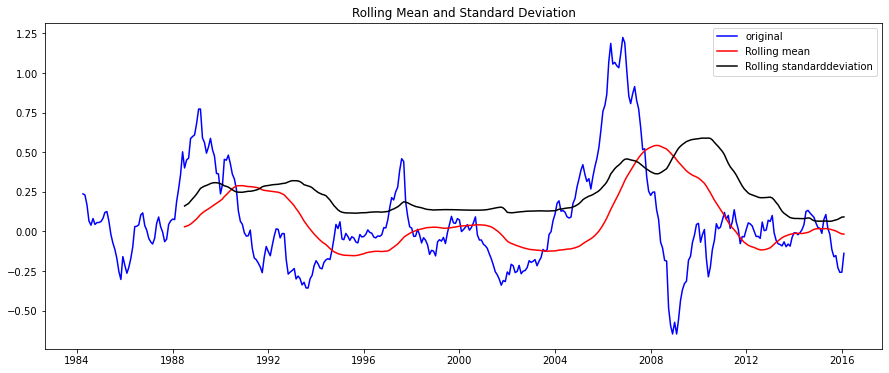

Results of Dickey Fuller Test:
Test Statistic                  -2.776901
p-value                          0.061650
#Lags Used                       1.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [11]:
test_stationarity(ts_log_mv_diff)

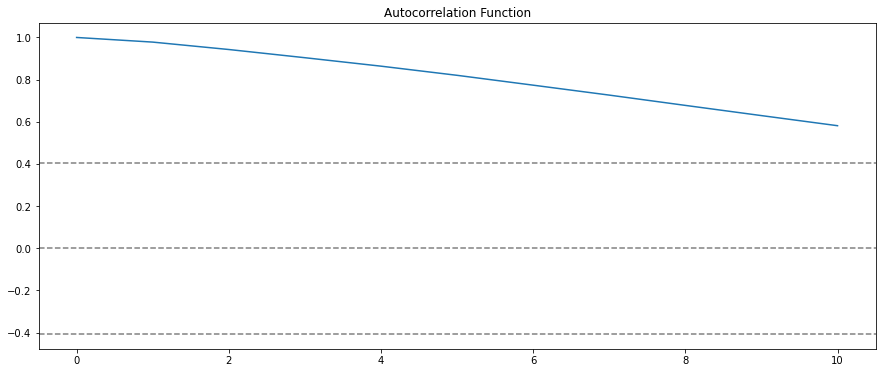

In [12]:
# plotting acf 
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,color='gray',linestyle='--')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.title('Autocorrelation Function')
plt.show()

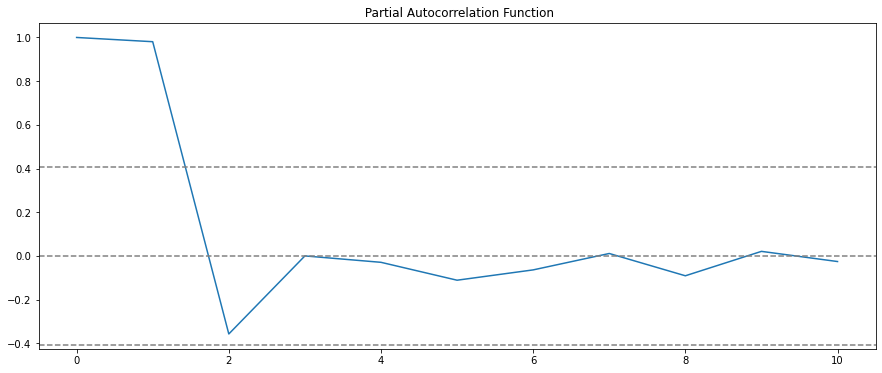

In [13]:
# plotting pacf 
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,color='gray',linestyle='--')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.title(' Partial Autocorrelation Function')
plt.show()

Text(0.5, 1.0, 'RSS : nan')

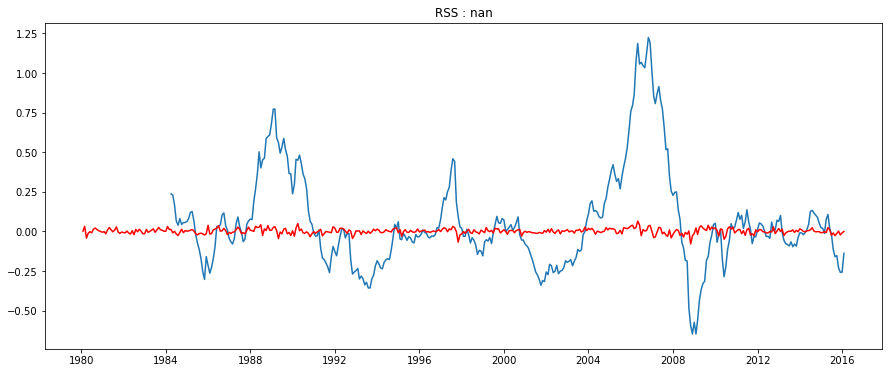

In [14]:
# build ARIMA model
model = ARIMA(ts_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='r')
plt.title('RSS : %.4f'%sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))

In [15]:
# storing the predicted values in Series
pred_ARIMA_diff_results = pd.Series(results_ARIMA.fittedvalues, copy = True)
pred_ARIMA_diff_results.head()

Date
1980-02-01    0.002030
1980-03-01    0.033049
1980-04-01   -0.042031
1980-05-01   -0.011002
1980-06-01   -0.001089
dtype: float64

In [16]:
pred_ARIMA_cumsum = pred_ARIMA_diff_results.cumsum()
pred_ARIMA_cumsum.head()

Date
1980-02-01    0.002030
1980-03-01    0.035079
1980-04-01   -0.006952
1980-05-01   -0.017955
1980-06-01   -0.019043
dtype: float64

In [17]:
pred_ARIMA_log = pd.Series(ts_log.iloc[0], index = ts_log.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_cumsum,fill_value=0)
pred_ARIMA_log.head()

Date
1980-01-01    6.651339
1980-02-01    6.653369
1980-03-01    6.686418
1980-04-01    6.644387
1980-05-01    6.633384
dtype: float64

Text(0.5, 1.0, 'RMSE: 429.0141')

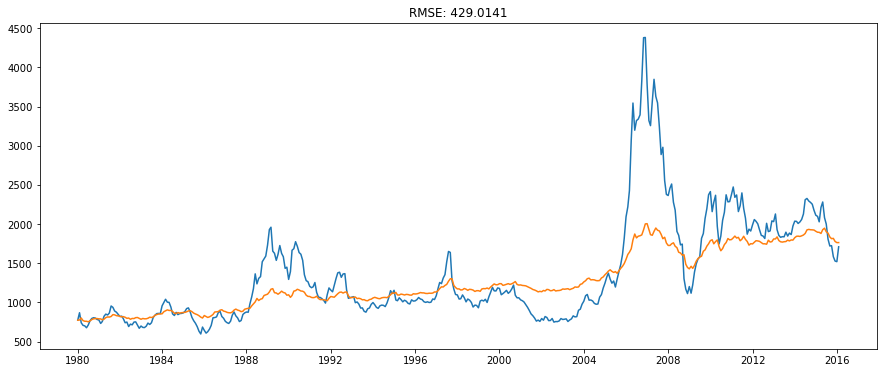

In [20]:
# Calculate forecasts
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(ts)
plt.plot(pred_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_ARIMA-ts)**2)/len(ts)))